In [2]:
!mkdir -p /content/data
!tar -xzf /content/CUB_200_2011.tgz -C /content/data/


In [3]:
!ls /content/data/CUB_200_2011 | head

attributes
bounding_boxes.txt
classes.txt
image_class_labels.txt
images
images.txt
parts
README
train_test_split.txt


✅ Loaded 5994 training and 5794 testing images.
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:04<00:00, 125MB/s]


Epoch 01 | Loss: 5.2908 | Train acc: 2.50% | Test acc: 34.12%
Epoch 02 | Loss: 5.2461 | Train acc: 17.15% | Test acc: 34.31%
Epoch 03 | Loss: 5.1780 | Train acc: 24.97% | Test acc: 35.92%
Epoch 04 | Loss: 5.0952 | Train acc: 30.71% | Test acc: 35.26%
Epoch 05 | Loss: 5.0032 | Train acc: 35.50% | Test acc: 36.23%
Epoch 06 | Loss: 4.9036 | Train acc: 38.41% | Test acc: 37.12%
Epoch 07 | Loss: 4.7967 | Train acc: 42.63% | Test acc: 35.28%
Epoch 08 | Loss: 4.6841 | Train acc: 45.30% | Test acc: 40.20%
Epoch 09 | Loss: 4.5701 | Train acc: 50.07% | Test acc: 41.72%
Epoch 10 | Loss: 4.4511 | Train acc: 53.84% | Test acc: 45.05%
Epoch 11 | Loss: 4.3336 | Train acc: 55.97% | Test acc: 46.63%
Epoch 12 | Loss: 4.2146 | Train acc: 61.48% | Test acc: 46.50%
Epoch 13 | Loss: 4.0983 | Train acc: 64.50% | Test acc: 50.09%
Epoch 14 | Loss: 3.9817 | Train acc: 68.77% | Test acc: 51.04%
Epoch 15 | Loss: 3.8690 | Train acc: 70.90% | Test acc: 50.19%
Epoch 16 | Loss: 3.7586 | Train acc: 74.02% | Test acc: 

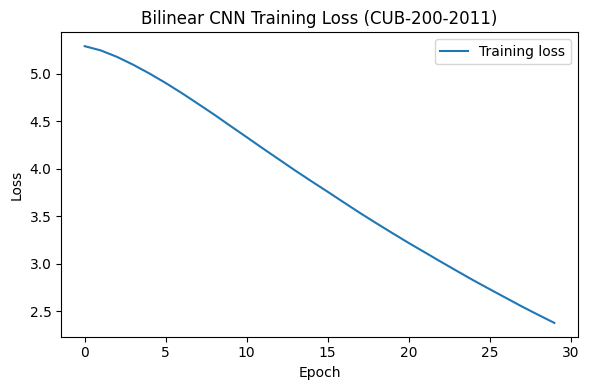

In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# ============================================================
# Dataset Definition
# ============================================================
class CUBDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        img_files = pd.read_csv(os.path.join(root, "images.txt"), sep=" ", names=["img_id", "filepath"])
        labels = pd.read_csv(os.path.join(root, "image_class_labels.txt"), sep=" ", names=["img_id", "target"])
        split = pd.read_csv(os.path.join(root, "train_test_split.txt"), sep=" ", names=["img_id", "is_training_img"])
        df = img_files.merge(labels, on="img_id").merge(split, on="img_id")
        df = df[df["is_training_img"] == int(train)]
        self.paths = df["filepath"].values
        self.targets = df["target"].values - 1  # ensure 0-indexed

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.paths[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.targets[idx]
        if self.transform: img = self.transform(img)
        return img, label


# ============================================================
# Bilinear CNN Model
# ============================================================
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        # Use pretrained backbone (VGG16 conv layers only)
        backbone = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
        self.features = nn.Sequential(*list(backbone.children())[:-1])  # remove last maxpool

        self.num_features = 512  # final conv feature channels from VGG16
        self.fc = nn.Linear(self.num_features * self.num_features, num_classes)

        # Initialize classifier weights
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        # Extract features
        x = self.features(x)           # (B, 512, 14, 14)
        B, C, H, W = x.size()

        # Bilinear pooling
        x = x.view(B, C, H * W)        # (B, 512, 196)
        x = torch.bmm(x, x.transpose(1, 2)) / (H * W)  # (B, 512, 512)
        x = x.view(B, C * C)           # Flatten

        # Signed square root
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)
        # L2 normalize
        x = F.normalize(x)

        logits = self.fc(x)
        return logits


# ============================================================
# Training & Evaluation
# ============================================================
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    return total_loss / len(loader), total_correct / total_samples


@torch.no_grad()
def test(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item()
        preds = logits.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    return total_loss / len(loader), total_correct / total_samples


# ============================================================
# Main
# ============================================================
if __name__ == "__main__":
    data_root = "data/CUB_200_2011"

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # larger for better detail capture
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_data = CUBDataset(data_root, train=True, transform=transform)
    test_data = CUBDataset(data_root, train=False, transform=transform)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=0)
    print(f"✅ Loaded {len(train_data)} training and {len(test_data)} testing images.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BilinearCNN(num_classes=200).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)

    num_epochs = 30
    best_acc = 0.0
    loss_hist, acc_hist = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1:02d} | Loss: {train_loss:.4f} | Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}%")
        loss_hist.append(train_loss); acc_hist.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_bcnn.pt")

    print(f"🎯 Best test accuracy: {best_acc*100:.2f}%")

    # === Plot loss ===
    plt.figure(figsize=(6,4))
    plt.plot(loss_hist, label="Training loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Bilinear CNN Training Loss (CUB-200-2011)")
    plt.legend(); plt.tight_layout(); plt.show()
